In [ ]:
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('creditcard.csv')
print(f'Data shape: {np.shape(df)}')
print(df.isnull().sum())
df.head()

Data shape: (284807, 31)
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Text(0, 0.5, 'Class')

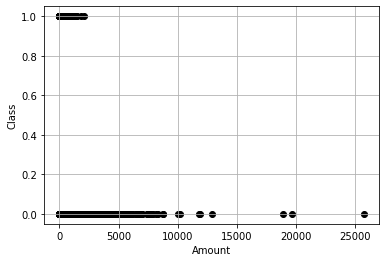

In [ ]:
plt.scatter(df['Amount'], df['Class'], color = 'black')
plt.grid(True)
plt.xlabel('Amount')
plt.ylabel('Class')

Normal: 284315 -- Fraude: 492


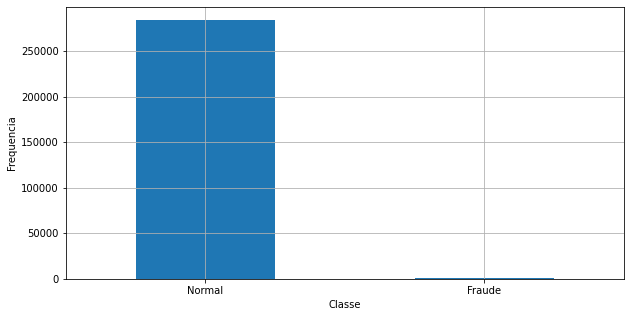

In [ ]:
plt.figure(0, figsize = (10,5))
count_val = pd.value_counts(df['Class']) #0: Normal; #1 Fraude

count_val.plot(kind = 'bar')
plt.xticks(ticks = [0,1], labels = ['Normal', 'Fraude'], rotation = 0)
plt.xlabel("Classe")
plt.ylabel('Frequencia')
plt.grid(True)

normal = df[df['Class'] == 0]
fraude = df[df['Class'] == 1]

print(f'Normal: {len(normal)} -- Fraude: {len(fraude)}')

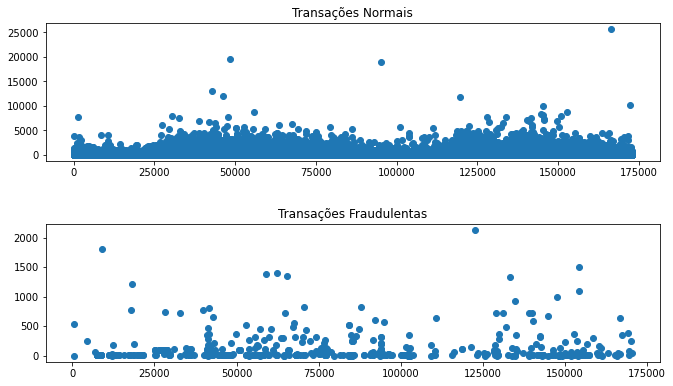

In [ ]:
plt.figure(0, figsize=(10,6))
plt.subplot(2,1,1)
plt.scatter(normal['Time'], normal['Amount'])
plt.title('Transações Normais')
plt.subplot(2,1,2)
plt.title('Transações Fraudulentas')
plt.scatter(fraude['Time'], fraude['Amount'])

plt.tight_layout(pad = 3)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, train_size = 0.8)

X_train = X_train[X_train['Class'] == 0]
X_train = X_train.drop(['Class', 'Time'], axis=1)

y_test = X_test[['Class']]
X_test = X_test.drop(['Class', 'Time'], axis = 1)

print(np.shape(X_train), np.shape(X_test))

(227446, 29) (56962, 29)


In [ ]:
sc = MinMaxScaler((0,1))
X_train = sc.fit_transform(X_train.values)
X_test = sc.fit_transform(X_test.values)
y_test = sc.fit_transform(y_test.values)

In [ ]:
from keras.layers import Dense, Input
from keras.models import Sequential
from keras.regularizers import l2

from keras.layers import Dense, Input
from keras.models import Sequential
from keras.regularizers import l2

def autoencoder():
    i1 = Input(shape = (X_train.shape[1], ))
    x1 = Dense(29, activation = 'sigmoid')(i1)
    x1 = Dense(14, activation = 'sigmoid')(x1)
    x1 = Dense(14, activation = 'relu')(x1)
    y = Dense(29, activation = 'sigmoid')(x1)
    
    model = Model(inputs = i1, outputs = y)
    
    return model

model = autoencoder()
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 29)                870       
_________________________________________________________________
dense_98 (Dense)             (None, 14)                420       
_________________________________________________________________
dense_99 (Dense)             (None, 14)                210       
_________________________________________________________________
dense_100 (Dense)            (None, 29)                435       
Total params: 1,935
Trainable params: 1,935
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_delta=1e-18)
checkpoint = ModelCheckpoint('rare_model.h5', monitor = 'val_loss', save_best_only= True)

In [ ]:
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics = ['accuracy'])

fit = model.fit(x = X_train, y = X_train, epochs = 25, batch_size = 256,
                shuffle = True, validation_data = (X_test, X_test), 
                callbacks = [reduce_lr, checkpoint],
                verbose = 1)

Train on 227446 samples, validate on 56962 samples
Epoch 25/25
227446/227446 [==============================] - 2s 9us/step - loss: 0.0020 - accuracy: 0.9846 - val_loss: 0.0274 - val_accuracy: 0.9499


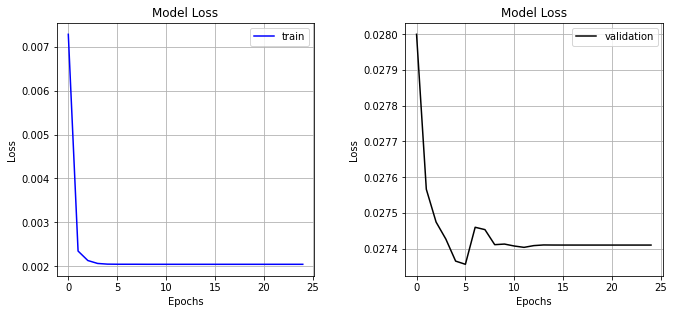

In [ ]:
plt.figure(0, figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(fit.history['loss'], label = 'train', color = 'blue')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(fit.history['val_loss'], label = 'validation', color = 'black')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)

plt.tight_layout(pad = 3)

In [ ]:
predictions = model.predict(X_test)
y_test = y_test.flatten()
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.027410,0.001633
std,0.003674,0.040374
min,0.018245,0.000000
25%,0.025340,0.000000
50%,0.026817,0.000000
75%,0.028759,0.000000
max,0.203851,1.000000


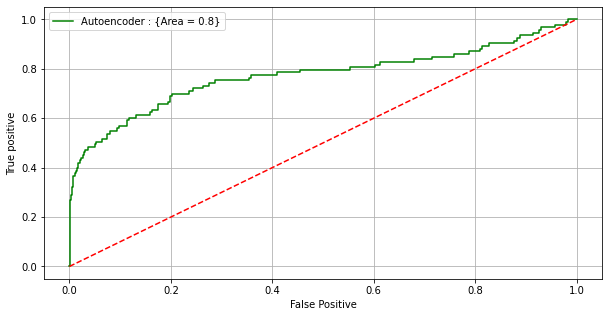

In [ ]:
'''
ROC curve plota verdadeiros positivos (y) por falso positivos (x), por diferentes threshold (?)
ROC é uma curva de probabilidade que representa o grau de separabilidade do algoritmo
Quanto mais proximo a curva estiver próximo do topo esquerdo, melhor a precisão do modelo
'''

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
mse = np.mean(((X_test - predictions)** 2), axis = 1)

auc = roc_auc_score(y_test, mse)
fpr, tpr, threshold = roc_curve(y_test, mse)

plt.figure(0, figsize = (10,5))
plt.plot(fpr, tpr, label = 'Autoencoder : {Area = %0.1f}'% auc, color = 'green') 
plt.plot([0,1],[0,1],'r--')
plt.xlabel('False Positive')
plt.ylabel('True positive')
plt.grid(True)
plt.legend()

In [ ]:
print(max(error_df['reconstruction_error']))
print(min(error_df['reconstruction_error']))
sep = 0.035

0.2038510347933068
0.018244832106612048


In [ ]:
y_pred = [1 if e > sep else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
print(conf_matrix)

[[55612  1257]
 [   53    40]]
